#  Gene Sets and Expression for Primary Site Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to both prune the number of genes/features as well as a source of pathway information to encorporate into layer design. Train modesl to predict primary site.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as pyplot

# fix random seed for reproducibility
np.random.seed(42)

# See https://github.com/h5py/h5py/issues/712
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" 

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load TCGA+TARGET+GTEX

Load expression and create a one hot output vector

In [2]:
X = pd.read_hdf("data/tcga_target_gtex.h5", "expression")
X.head()

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,-9.966042,-9.965816,-9.965880,4.4595,0.9343,-5.0116,7.5126,0.8164,-2.1140,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,5.326995,-9.9658
GTEX-1117F-0426-SM-5EGHI,-9.966042,-9.965816,-9.965880,1.1512,-1.2828,-6.5064,6.0777,-2.3147,0.5568,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,3.037565,-9.9658
GTEX-1117F-0526-SM-5EGHJ,-9.966042,-9.965816,-9.965880,5.2411,0.8488,-6.5064,10.0319,0.1257,-1.1172,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,4.302417,-9.9658
GTEX-1117F-0626-SM-5N9CS,-9.966042,-9.965816,-9.965880,5.4758,2.6325,-9.9658,9.7572,1.7702,-1.8836,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,4.248770,-9.9658
GTEX-1117F-0726-SM-5GIEN,-9.966042,-9.965816,-0.833902,4.5534,1.3051,-9.9658,7.7931,-0.0725,-2.2447,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,3.145838,-9.9658


In [3]:
Y = pd.read_hdf("data/tcga_target_gtex.h5", "labels")
Y.head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal
id,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0426-SM-5EGHI,Muscle - Skeletal,Muscle - Skeletal,Muscle,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0526-SM-5EGHJ,Artery - Tibial,Artery - Tibial,Blood Vessel,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0626-SM-5N9CS,Artery - Coronary,Artery - Coronary,Blood Vessel,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0726-SM-5GIEN,Heart - Atrial Appendage,Heart - Atrial Appendage,Heart,Normal Tissue,Female,GTEX,Normal


## Ingest Pathways

Load gene sets downloaded from msigdb filter out data to only include gene's present in the union of all the pathways

In [4]:
# Load gene sets from downloaded MSigDB gmt file (KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = { line.strip().split("\t")[0]: line.strip().split("\t")[2:] for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop any genes that are not in X - sort so that the order is the same as X_pruned.columns
gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values]) 
             for name, genes in gene_sets.items()}

# Find the union of all gene's in the gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X to only include genes in the gene sets
X_pruned = X.drop(labels=(set(X.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19126, 5172)


## Wrangle Labels, Train and Test Sets

Add one hot labels for primary site and stratify into test and train on primary site

In [5]:
# Convert  primary_site into numerical values for two-hot multi-class training
from sklearn.preprocessing import LabelEncoder
primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(primary_site_encoder.fit_transform(Y["primary_site"]), index=Y.index)

Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,primary_site_value
count,19126,19126,19126,19126,19126,19126,19126,19126.000000
unique,93,93,46,16,3,3,2,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN
freq,1212,1212,1846,9185,10453,10534,10530,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.651992
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.419634
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.000000


In [6]:
# Create one hots for training
from keras.utils import np_utils
Y_primary_site_one_hot = np_utils.to_categorical(Y["primary_site_value"])
print(Y_primary_site_one_hot[0:20000:5000])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
# Split into stratified training and test sets based primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pruned.values, Y["primary_site_value"]):
    X_train, X_test = X_pruned.values[train_index], X_pruned.values[test_index]
    y_train, y_test = Y_primary_site_one_hot[train_index], Y_primary_site_one_hot[test_index]
    primary_site_train, primary_site_test = Y["primary_site_value"].values[train_index], Y["primary_site_value"].values[test_index]

print(X_train.shape, X_test.shape)

(15300, 5172) (3826, 5172)


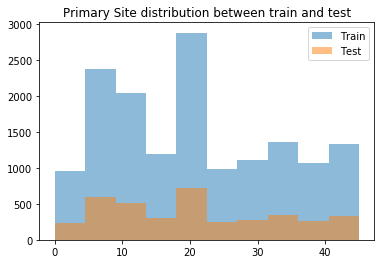

In [8]:
# Lets see how big each class is based on primary site
pyplot.hist(primary_site_train, alpha=0.5, label='Train')
pyplot.hist(primary_site_test, alpha=0.5, label='Test')
pyplot.legend(loc='upper right')
pyplot.title("Primary Site distribution between train and test")
pyplot.show()

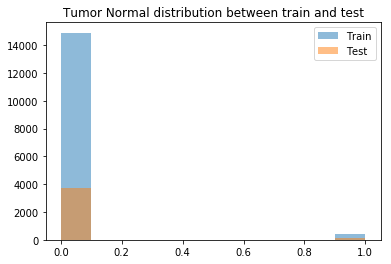

In [9]:
# Check tumor vs. normal stratification
pyplot.hist(y_train[:, 0], alpha=0.5, label='Train')
pyplot.hist(y_test[:, 0], alpha=0.5, label='Test')
pyplot.legend(loc='upper right')
pyplot.title("Tumor Normal distribution between train and test")
pyplot.show()

## Primary Site Classification
Classification of primary site with union of genes from all gene sets as input

In [10]:
%%time
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

epochs=10
batch_size=128

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(16, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),
    
    Dense(y_train.shape[1], activation='sigmoid')
]

model = Sequential(classify)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch", callbacks=callbacks)
print(model.metrics_names, model.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5172)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5172)              20688     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                165536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 46)                782       
Total para

In [11]:
# Save the model for separate inference
with open("models/primary_site.params.json", "w") as f:
    f.write(json.dumps({
        "labels": primary_site_encoder.classes_.tolist(),
        "genes": all_gene_set_genes}))

with open("models/primary_site.model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("models/primary_site.weights.h5")

## Primary Site Classification w/Per Pathway Sub-Network Input Layer
For each pathway build a custom input layer that extracts the expression levels for the genes in the pathway from the full input vector and feeds this into a dense single output hidden neuron. These are then aggregated and fed into a standard set of stacked layers and trained to classify tumor/norml and primary site. The hidden per pathway neurons are named after the pathway an 'may' indicate which pathway lead to a given classification.

In [12]:
# Convert list of gene names into list of indexes into the features of X_pruned
gene_set_indexes = {name: np.searchsorted(X_pruned.columns.values, genes) for name, genes in gene_sets.items()}
print("Pathway KEGG_ABC_TRANSPORTERS Gene Indexes:", gene_set_indexes["KEGG_ABC_TRANSPORTERS"])

Pathway KEGG_ABC_TRANSPORTERS Gene Indexes: [  11   12   13   14   15   16   17   18   19   20   21   22   23   24
   25   26   27   28   29   30   31   32   33   34   35   36   37   38
   39   40   41   42   43   44   45   46   47   48   49   50   51  848
 4692 4693]


In [13]:
%%time
from keras.models import Model, Sequential
from keras.layers import Input, Lambda, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.merge import concatenate
from keras import backend as K
import itertools

main_input = Input(shape=(X_train.shape[1],), name="main_input")

"""
Build per pathway sub-networks
"""
# Set to a small number (~4) for debugging, set to None to build all pathways
# max_num_pathways = 4
max_num_pathways = None 

# Extract the features/gene's for each pathway from the aggregate x input vector
pathways = [Lambda(lambda x: K.concatenate([x[:, i:i+1] for i in indexes]))(main_input)
            for name, indexes in itertools.islice(gene_set_indexes.items(), max_num_pathways)]

# Add a dense hidden layer per pathway with width proportional to the number of genes in the pathway
# pathways = [Dense(max(2, len(i)//4), activation='relu')(p) for p, i in zip(pathways, gene_set_indexes.values())]

# Add a named binary output for each pathway 
# pathways = [Dense(1, activity_regularizer=regularizers.l1(1e-5), activation='relu', name=name)(p) 
#             for p, name in zip(pathways, gene_set_indexes.keys())]

pathways = [Dropout(0.5)(Dense(1, activity_regularizer=regularizers.l1(1e-5), activation='relu', name=name)(p))
            for p, name in zip(pathways, gene_set_indexes.keys())]

# Concatenate the binary outputs of each of the sub-networks back into a single vector
x = keras.layers.concatenate(pathways)
           
"""
Add traditional stacked network for final multi-label classification
"""
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
    
x = Dense(8, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(y_train.shape[1], activation='sigmoid')(x)

model = Model(inputs=[main_input], outputs=[x])
# print(model.summary())  # Too detailed when building full set of pathways
print("Trainable params::", np.sum([np.product(v.shape) for v in model.trainable_weights]).value)

Trainable params:: 16343
CPU times: user 1min 34s, sys: 3.16 s, total: 1min 37s
Wall time: 1min 37s


In [14]:
%%time
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="data/logs/{}".format(time()))

epochs=10
batch_size=128

print("Compiling and training...")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch", 
          callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max"), tensorboard])
print(model.metrics_names, model.evaluate(X_test, y_test))

Compiling and training...
Epoch 1/10
15300/15300 [==============================] - 36s 2ms/step - loss: 1.0824 - acc: 0.7416
Epoch 2/10
15300/15300 [==============================] - 15s 994us/step - loss: 0.5597 - acc: 0.8443
Epoch 3/10
15300/15300 [==============================] - 15s 993us/step - loss: 0.3210 - acc: 0.9341
Epoch 4/10
15300/15300 [==============================] - 15s 1ms/step - loss: 0.2274 - acc: 0.9691
Epoch 5/10
15300/15300 [==============================] - 15s 998us/step - loss: 0.1898 - acc: 0.9741
Epoch 00005: early stopping
3826/3826 [==============================] - 27s 7ms/step
['loss', 'acc'] [0.10420070022297853, 0.9782609340724556]
CPU times: user 6min 1s, sys: 3min, total: 9min 2s
Wall time: 3min 23s
